# Pokemon ML Challenge

Will you be able to predict the outcome of future matches? To do it you will have the pokemon characteristics and the results of previous combats.

Three files are available. The first one contains the pokemon characteristics (the first column being the id of the pokemon). The second one contains information about previous combats. The first two columns contain the ids of the combatants and the third one the id of the winner. Important: The pokemon in the first columns attacks first.

The goal is to develop a Machine Learning model able to predict the result of future pokemon combats.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, random as rnd
%matplotlib inline

In [2]:
combats_df = pd.read_csv("combats.csv")
pokemon_df = pd.read_csv("pokemon.csv")
tests_df = pd.read_csv("tests.csv")
chart_df = pd.read_csv("chart.csv")

In [3]:
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
#             800 non-null int64
Name          799 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 69.6+ KB


In [4]:
# Fixing the missing information on Primeape
pokemon_df.loc[pokemon_df['#'] == 63, 'Name'] = 'Primeape'
pokemon_df[pokemon_df['#'] == 63]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False


## Goal #1 : Predict outcome of fight

For simplicity sake, we suppose that a Pokemon can only use moves of its own type.
For example, a *Charizard* can use only *Fire&Flying* techniques, while a *Primeape* can only use *Fighting* techniques.

Given the chart of effectiveness *chart.csv*, one can try to predict the result of a match by looking at the types and characteristics of the pokemon.

Information needed:

|Pkm1|Types|Chars|Pkm2|Types|Chars|T_ij coeff|
|----|-----|-----|----|-----|-----|----------|

Where *T\_ij* stands for effectiveness of type *i* on type *j*. The possible values of *T\_ij* are:

- 0.25 if the type of attack is weak against both of the enemy's types
- 0.5 if weak only against one, and normal against the other
- 1 if normal against both enemy's types
- 1.5 if super-effective against one type, normal against the other
- 2 if super-effective against both types

*T\_ij* can be computed by a simple multiplication of the effectiveness, which will only upscale coefficient 1.5 to 2 and 2 to 4.

In [5]:
# Transform the "Winner" column into 0/1 to make it a problem of classification
combats_df['Winner'] = combats_df.apply(lambda x : 0 if x['First_pokemon']==x['Winner'] else 1, axis=1)
combats_df.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,1
1,702,701,1
2,191,668,1
3,237,683,1
4,151,231,0


In [6]:
# Get types and characteristics for 'First_pokemon'
# exclude 'Name', 'Generation' and 'Legendary' columns of pokemon_df
pok_info_df = pokemon_df.drop(pokemon_df[['Name', 'Generation']], axis = 1)
pok_info_df.head()

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Grass,Poison,45,49,49,65,65,45,False
1,2,Grass,Poison,60,62,63,80,80,60,False
2,3,Grass,Poison,80,82,83,100,100,80,False
3,4,Grass,Poison,80,100,123,122,120,80,False
4,5,Fire,NaN,39,52,43,60,50,65,False


In [7]:
# Join types and chars with 'First_pokemon'
new_cols_name = {
    'First_pokemon': 'P1', 'Type 1': 'T11', 'Type 2': 'T21',
    'HP': 'HP1', 'Attack': 'A1', 'Defense': 'D1', 
    'Sp. Atk': 'SA1', 'Sp. Def': 'SD1', 'Speed': 'S1', 'Legendary': 'L1'
}
temp_df = pok_info_df.rename(columns={'#':'First_pokemon'})
pok1_info = combats_df[['First_pokemon']].join(temp_df.set_index('First_pokemon'), on='First_pokemon')\
            .rename(index=str, columns=new_cols_name)
pok1_info.head()

,P1,T11,T21,HP1,A1,D1,SA1,SD1,S1,L1
0,266,Rock,Ground,50,64,50,45,50,41,False
1,702,Grass,Fighting,91,90,72,90,129,108,True
2,191,Fairy,Flying,55,40,85,80,105,40,False
3,237,Fire,NaN,40,40,40,70,40,20,False
4,151,Rock,Water,70,60,125,115,70,55,False


In [8]:
# Join types and chars with 'Second_pokemon'
new_cols_name = {
    'Second_pokemon': 'P2', 'Type 1': 'T12', 'Type 2': 'T22',
    'HP': 'HP2', 'Attack': 'A2', 'Defense': 'D2', 
    'Sp. Atk': 'SA2', 'Sp. Def': 'SD2', 'Speed': 'S2', 'Legendary': 'L2'
}
temp_df = pok_info_df.rename(columns={'#':'Second_pokemon'})
pok2_info = combats_df[['Second_pokemon']].join(temp_df.set_index('Second_pokemon'), on='Second_pokemon')\
            .rename(index=str, columns=new_cols_name)
pok2_info.head()

,P2,T12,T22,HP2,A2,D2,SA2,SD2,S2,L2
0,298,Grass,Dark,70,70,40,60,40,60,False
1,701,Rock,Fighting,91,129,90,72,90,108,True
2,668,Psychic,NaN,75,75,75,125,95,40,False
3,683,Dragon,NaN,77,120,90,60,90,48,False
4,231,Bug,Rock,20,10,230,10,230,5,False


In [9]:
# Join the characteristics to the combats_df
combats_df = combats_df.rename(index=str, columns={'First_pokemon':'P1', 'Second_pokemon':'P2', 'Winner':'W'})
combats_df = combats_df.join(pok1_info.set_index('P1'), on=['P1'], how='left').drop_duplicates()\
                                .join(pok2_info.set_index('P2'), on='P2', how='left').drop_duplicates()
# combats_df_ren = combats_df_ren.join(pok1_info[['P1', 'T11', 'T21']].set_index('P1'), on='P1', how='left')
combats_df.head()

,P1,P2,W,T11,T21,HP1,A1,D1,SA1,SD1,...,L1,T12,T22,HP2,A2,D2,SA2,SD2,S2,L2
0,266,298,1,Rock,Ground,50,64,50,45,50,...,False,Grass,Dark,70,70,40,60,40,60,False
1,702,701,1,Grass,Fighting,91,90,72,90,129,...,True,Rock,Fighting,91,129,90,72,90,108,True
2,191,668,1,Fairy,Flying,55,40,85,80,105,...,False,Psychic,NaN,75,75,75,125,95,40,False
3,237,683,1,Fire,NaN,40,40,40,70,40,...,False,Dragon,NaN,77,120,90,60,90,48,False
4,151,231,0,Rock,Water,70,60,125,115,70,...,False,Bug,Rock,20,10,230,10,230,5,False


### Data processing

In [10]:
# Reduce #features by storing the difference between statistics
def stats_diff(x):
    stats = ['HP', 'A', 'D', 'SA', 'SD', 'S']
    for s in stats:
        x[s] = x[s+'1'] - x[s+'2']
        x = x.drop([s+'1',s+'2'])
    return x

combats_df = combats_df.apply(lambda x : stats_diff(x), axis=1)

In [11]:
types = chart_df.columns.values[1:]
factors = {}
i = 0
for t in types:
    factors[t] = {}
    for ty in types:
        value = chart_df[chart_df.Attacking == t]
        factors[t][ty] = value[ty][i]
        factors[t]['nan'] = 1
    i += 1
factors['nan'] = {}
for ty in types:
    factors['nan'][ty] = 1
    factors['nan']['nan'] = 1

factors['Water']['Fire']

2.0

In [15]:
# Compute effectiveness of moveset
def effectiveness(x):
    # x['T11'] and x['T21'] are P1 types
    T11 = str(x['T11'])
    T21 = str(x['T21'])
    T12 = str(x['T12'])
    T22 = str(x['T22'])
#     print(str(T11)+', '+str(T21)+', '+str(T12)+', '+str(T22))
    x['E1'] = factors[T11][T12]*factors[T11][T22]*factors[T21][T12]*factors[T21][T22]
    x['E2'] = factors[T12][T11]*factors[T12][T21]*factors[T22][T11]*factors[T22][T21]
    x = x.drop(['T11', 'T12', 'T21', 'T22'], axis=0)
    return x
combats_df = combats_df.apply(lambda x : effectiveness(x), axis = 1)
combats_df.head()

,P1,P2,W,L1,L2,HP,A,D,SA,SD,S,E1,E2
0,266,298,1,False,False,-20,-6,10,-15,10,-19,0.5,4.0
1,702,701,1,True,True,0,-39,-18,18,39,0,4.0,0.5
2,191,668,1,False,False,-20,-35,10,-45,10,0,1.0,1.0
3,237,683,1,False,False,-37,-80,-50,10,-50,-28,0.5,1.0
4,151,231,0,False,False,50,50,-105,105,-160,50,4.0,1.0


## Prediction time!

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [17]:
# Divide the training "combats" set in X and Y
X = combats_df.drop(['W', 'P1', 'P2'],axis=1)
y = combats_df['W']

In [18]:
n_iter = 5

# RandomForestClassifier
rfc = RandomForestClassifier()
# KNeighborsClassifier
knn = KNeighborsClassifier()
# MLPClassifier
mlp = MLPClassifier()
# SGDClassifier
gnb = GaussianNB()

classifiers = [rfc, knn, mlp, gnb]

    
acc = [0 for x in classifiers]
for i in range(0, n_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=math.floor(rnd.random()*100))
    for j in range(0,len(classifiers)):
        cl = classifiers[j]
        cl.fit(X_train, y_train)
        acc[j] += accuracy_score(y_test, cl.predict(X_test))
    
for j in range(0,len(classifiers)):
    acc[j] = acc[j] / n_iter
    print('Accuracy of model %d: '%j +str(acc[j]))

Accuracy of model 0: 0.9512487386478305
Accuracy of model 1: 0.9030146316851665
Accuracy of model 2: 0.937058526740666
Accuracy of model 3: 0.8066725529767911


Feature ranking:
1. feature 7: S (0.702651)
2. feature 3: A (0.076890)
3. feature 5: SA (0.061066)
4. feature 8: E1 (0.036326)
5. feature 2: HP (0.034085)
6. feature 6: SD (0.032344)
7. feature 4: D (0.028131)
8. feature 9: E2 (0.019744)
9. feature 1: L2 (0.005170)
10. feature 0: L1 (0.003593)


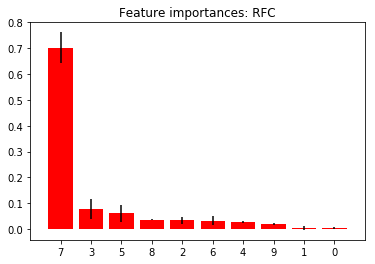

In [19]:
# Display feature importances of RFC
features = list(X_train.columns.values)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances: RFC")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()